<a href="https://colab.research.google.com/github/Didier06/IA_licence_pro_chimie/blob/main/Aromes_SVM_RadomForest_NaivesBayles" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# üå∏ IA & Chimie ‚Äì Mol√©cules aromatiques de parfumerie  
### Universit√© C√¥te d‚ÄôAzur ‚Äî UE IA & Chimie ‚Äî Fablab Valrose

### üéØ Objectif du TP  
Utiliser des m√©thodes d‚Äô**intelligence artificielle** (Na√Øve Bayes, SVM, Random Forest)  
pour **classer des mol√©cules odorantes** selon leur famille olfactive  
(floral, fruit√©, √©pic√©, sucr√©, frais, agrume).

Les √©tudiants apprendront √† :  
- extraire descripteurs mol√©culaires avec **RDKit**,  
- entra√Æner plusieurs mod√®les d‚ÄôIA,  
- comparer leurs performances,  
- tester et visualiser de nouvelles mol√©cules.

---


# üå∏ IA & Chimie ‚Äì Mol√©cules aromatiques de parfumerie  
### Universit√© C√¥te d‚ÄôAzur ‚Äî UE IA & Chimie ‚Äî Fablab Valrose

### üéØ Objectif du TP  
Utiliser des m√©thodes d‚Äô**intelligence artificielle** (Na√Øve Bayes, SVM, Random Forest)  
pour **classer des mol√©cules odorantes** selon leur famille olfactive  
(floral, fruit√©, √©pic√©, sucr√©, frais, agrume).

Les √©tudiants apprendront √† :  
- extraire descripteurs mol√©culaires avec **RDKit**,  
- entra√Æner plusieurs mod√®les d‚ÄôIA,  
- comparer leurs performances,  
- tester et visualiser de nouvelles mol√©cules.

---


In [38]:
!pip install rdkit pubchempy scikit-learn matplotlib ipywidgets pandas
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
import pandas as pd, matplotlib.pyplot as plt, pubchempy as pcp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
from IPython.display import display, HTML


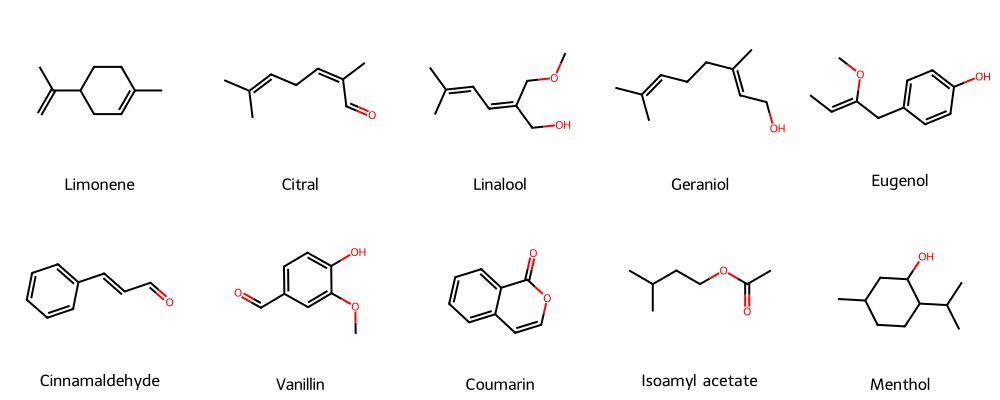

In [39]:
data = [
    {"name": "Limonene", "smiles": "CC1=CCC(CC1)C(=C)C", "family": "Citrus"},
    {"name": "Citral", "smiles": "CC(C)=CCC=C(C)C=O", "family": "Citrus"},
    {"name": "Linalool", "smiles": "CC(C)=CC=C(CO)COC", "family": "Floral"},
    {"name": "Geraniol", "smiles": "CC(C)=CCCC(C)=CCO", "family": "Floral"},
    {"name": "Eugenol", "smiles": "CC=C(CC1=CC=C(O)C=C1)OC", "family": "Spicy"},
    {"name": "Cinnamaldehyde", "smiles": "C1=CC=C(C=C1)C=CC=O", "family": "Spicy"},
    {"name": "Vanillin", "smiles": "COC1=CC(=CC=C1O)C=O", "family": "Sweet"},
    {"name": "Coumarin", "smiles": "C1=CC=C2C(=O)OC=CC2=C1", "family": "Sweet"},
    {"name": "Isoamyl acetate", "smiles": "CC(C)CCOC(=O)C", "family": "Fruity"},
    {"name": "Menthol", "smiles": "CC(C)C1CCC(C)CC1O", "family": "Fresh"},
]
df = pd.DataFrame(data)
mols = [Chem.MolFromSmiles(s) for s in df.smiles]
Draw.MolsToGridImage(mols, molsPerRow=5, legends=df.name.tolist())


In [40]:
molecules_pubchem = [
    ("Ethyl butyrate", "Fruity"),
    ("Methyl anthranilate", "Floral"),
    ("Helional", "Fresh"),
    ("Isoeugenol", "Spicy"),
    ("Methyl cinnamate", "Sweet"),
]

pubchem_data = []
for name, family in molecules_pubchem:
    try:
        c = pcp.get_compounds(name, "name")[0]
        smiles = c.canonical_smiles
        pubchem_data.append({"name": name, "smiles": smiles, "family": family})
        print(f"‚úÖ {name} ajout√© ({smiles})")
    except Exception as e:
        print(f"‚ö†Ô∏è {name} introuvable : {e}")

df_pubchem = pd.DataFrame(pubchem_data)
df_full = pd.concat([df, df_pubchem], ignore_index=True).drop_duplicates("smiles")
print(f"üì¶ Jeu total : {len(df_full)} mol√©cules")


/tmp/ipython-input-1148205247.py:13: PubChemPyDeprecationWarning: canonical_smiles is deprecated: Use connectivity_smiles instead
  smiles = c.canonical_smiles


‚úÖ Ethyl butyrate ajout√© (CCCC(=O)OCC)
‚úÖ Methyl anthranilate ajout√© (COC(=O)C1=CC=CC=C1N)
‚úÖ Helional ajout√© (CC(CC1=CC2=C(C=C1)OCO2)C=O)
‚úÖ Isoeugenol ajout√© (CC=CC1=CC(=C(C=C1)O)OC)
‚úÖ Methyl cinnamate ajout√© (COC(=O)C=CC1=CC=CC=C1)
üì¶ Jeu total : 15 mol√©cules


In [41]:
# üß© Extension du dataset PubChem : plus de mol√©cules
molecules_extra = [
    ("Benzaldehyde", "Sweet"),
    ("Methyl salicylate", "Fresh"),
    ("Alpha-ionone", "Floral"),
    ("Beta-caryophyllene", "Spicy"),
    ("Citronellal", "Citrus"),
    ("Nerolidol", "Floral"),
    ("Hexyl acetate", "Fruity"),
    ("Anisaldehyde", "Sweet"),
    ("Lyral", "Floral"),
    ("Musk ketone", "Sweet"),
]

extra_data = []
for name, fam in molecules_extra:
    try:
        compound = pcp.get_compounds(name, "name")[0]
        smiles = compound.canonical_smiles
        extra_data.append({"name": name, "smiles": smiles, "family": fam})
        print(f"‚úÖ {name} ajout√©")
    except Exception as e:
        print(f"‚ö†Ô∏è {name} introuvable : {e}")

df_extra = pd.DataFrame(extra_data)
df_full = pd.concat([df_full, df_extra], ignore_index=True).drop_duplicates("smiles")
print(f"üì¶ Nouveau total : {len(df_full)} mol√©cules")


/tmp/ipython-input-3620674702.py:19: PubChemPyDeprecationWarning: canonical_smiles is deprecated: Use connectivity_smiles instead
  smiles = compound.canonical_smiles


‚úÖ Benzaldehyde ajout√©
‚úÖ Methyl salicylate ajout√©
‚úÖ Alpha-ionone ajout√©
‚úÖ Beta-caryophyllene ajout√©
‚úÖ Citronellal ajout√©
‚úÖ Nerolidol ajout√©
‚úÖ Hexyl acetate ajout√©
‚úÖ Anisaldehyde ajout√©
‚úÖ Lyral ajout√©
‚úÖ Musk ketone ajout√©
üì¶ Nouveau total : 25 mol√©cules


In [42]:
def compute_descriptors(smi):
    mol = Chem.MolFromSmiles(smi)
    return dict(
        MolWt=Descriptors.MolWt(mol),
        MolLogP=Descriptors.MolLogP(mol),
        NumAromaticRings=Descriptors.NumAromaticRings(mol),
        TPSA=Descriptors.TPSA(mol),
        NumRotatableBonds=Descriptors.NumRotatableBonds(mol)
    )

desc = df_full.smiles.apply(compute_descriptors)
df_full = pd.concat([df_full, pd.DataFrame(list(desc))], axis=1)

X = df_full[["MolWt","MolLogP","NumAromaticRings","TPSA","NumRotatableBonds"]]
y = df_full["family"]

# üîß Ajustement automatique du test_size
n_classes = len(y.unique())
test_size = max(0.4, n_classes / len(y))
print(f"üßÆ Ajustement automatique du jeu de test : test_size={round(test_size,2)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y, random_state=42
)


üßÆ Ajustement automatique du jeu de test : test_size=0.4


In [43]:
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import numpy as np

# G√©n√©rateur ECFP4 (radius=2, nBits=1024)
gen = GetMorganGenerator(radius=2, fpSize=1024)

def smiles_to_ecfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(1024)
    fp = gen.GetFingerprint(mol)
    return np.array(list(map(int, fp.ToBitString())))

X = np.array(list(df_full["smiles"].apply(smiles_to_ecfp)))
y = df_full["family"]

print(f"‚úÖ Empreintes ECFP4 calcul√©es : matrice {X.shape}")


‚úÖ Empreintes ECFP4 calcul√©es : matrice (25, 1024)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

models = {
    "Na√Øve Bayes": GaussianNB(),
    "SVM (RBF)": make_pipeline(StandardScaler(), SVC(kernel="rbf", C=2, gamma="auto")),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=0),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f"üéØ {name}: pr√©cision {acc:.2f}")


üéØ Na√Øve Bayes: pr√©cision 0.50
üéØ SVM (RBF): pr√©cision 0.38
üéØ Random Forest: pr√©cision 0.50


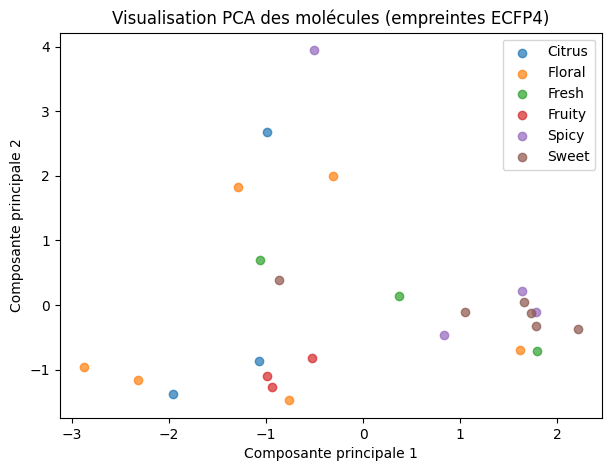

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2D = pca.fit_transform(X)

pca_df = pd.DataFrame(X_2D, columns=["PC1","PC2"])
pca_df["family"] = y.values

plt.figure(figsize=(7,5))
for fam in sorted(pca_df["family"].unique()):
    subset = pca_df[pca_df["family"] == fam]
    plt.scatter(subset["PC1"], subset["PC2"], label=fam, alpha=0.7)
plt.title("Visualisation PCA des mol√©cules (empreintes ECFP4)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.show()


üîÆ Famille pr√©dite : Sweet


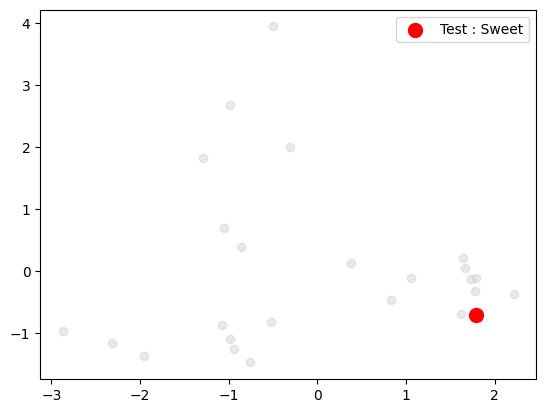

In [46]:
# Exemple : pr√©dire et positionner Methyl salicylate
test_molecule = "COC(=O)C1=CC=CC=C1O"
mol = Chem.MolFromSmiles(test_molecule)
fp = smiles_to_ecfp(test_molecule).reshape(1, -1)
pred = models["Random Forest"].predict(fp)[0]
print(f"üîÆ Famille pr√©dite : {pred}")

# Projection PCA de la mol√©cule test
test_proj = pca.transform(fp)
plt.scatter(pca_df["PC1"], pca_df["PC2"], c='lightgray', alpha=0.5)
plt.scatter(test_proj[0,0], test_proj[0,1], c='red', s=100, label=f"Test : {pred}")
plt.legend()
plt.show()


In [47]:
# Versiopn de Test interactif : saisie d'un SMILES √† projeter dans la PCA

from IPython.display import display
import ipywidgets as widgets

# Zone de saisie
smiles_input = widgets.Text(
    value="COC(=O)C1=CC=CC=C1O",  # Methyl salicylate par d√©faut
    description="SMILES :",
    placeholder="Ex: CC(C)=CC=C(CO)COC pour Linalool",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

# Bouton d'ex√©cution
button = widgets.Button(description="Pr√©dire et afficher", button_style="info")
output = widgets.Output()

def predict_and_plot(b):
    with output:
        output.clear_output()
        test_molecule = smiles_input.value.strip()
        mol = Chem.MolFromSmiles(test_molecule)
        if mol is None:
            print("‚ö†Ô∏è SMILES invalide, v√©rifiez la syntaxe.")
            return
        display(Draw.MolToImage(mol, size=(250,250)))

        # Calcul de l'empreinte
        fp = smiles_to_ecfp(test_molecule).reshape(1, -1)
        pred = models["Random Forest"].predict(fp)[0]
        print(f"üîÆ Famille pr√©dite : {pred}")

        # Projection PCA
        test_proj = pca.transform(fp)
        plt.figure(figsize=(6,4))
        plt.scatter(pca_df["PC1"], pca_df["PC2"], c='lightgray', alpha=0.5, label="Ensemble d'entra√Ænement")
        plt.scatter(test_proj[0,0], test_proj[0,1], c='red', s=120, label=f"Mol√©cule test : {pred}")
        plt.title("Visualisation PCA de la mol√©cule test√©e")
        plt.xlabel("PC1"); plt.ylabel("PC2")
        plt.legend()
        plt.show()

button.on_click(predict_and_plot)
display(smiles_input, button, output)


Text(value='COC(=O)C1=CC=CC=C1O', description='SMILES :', layout=Layout(width='70%'), placeholder='Ex: CC(C)=C‚Ä¶

Button(button_style='info', description='Pr√©dire et afficher', style=ButtonStyle())

Output()